In [1]:
options(warn=-1)
suppressMessages({library('dplyr')
library('tidyr')
library("ggplot2")
library("GenomicRanges")
library("GGally")})

In [2]:
GGscatterhex <- function(data, mapping, lims...) {
  x <- GGally::eval_data_col(data, mapping$x)
  y <- GGally::eval_data_col(data, mapping$y)
  df <- data.frame(x = x, y = y)
  pp <- ggplot(df, aes(x=x, y=y)) + geom_hex(bins=100) + 
  xlim(lims[1], lims[2]) + ylim(lims[1], lims[2]) + scale_fill_continuous(limits = c(0, lims[3]), oob = scales::squish)
  return(pp)}

# Plotting hexagonal heatmaps of pairwise comparison of ChIP signals in DHSs

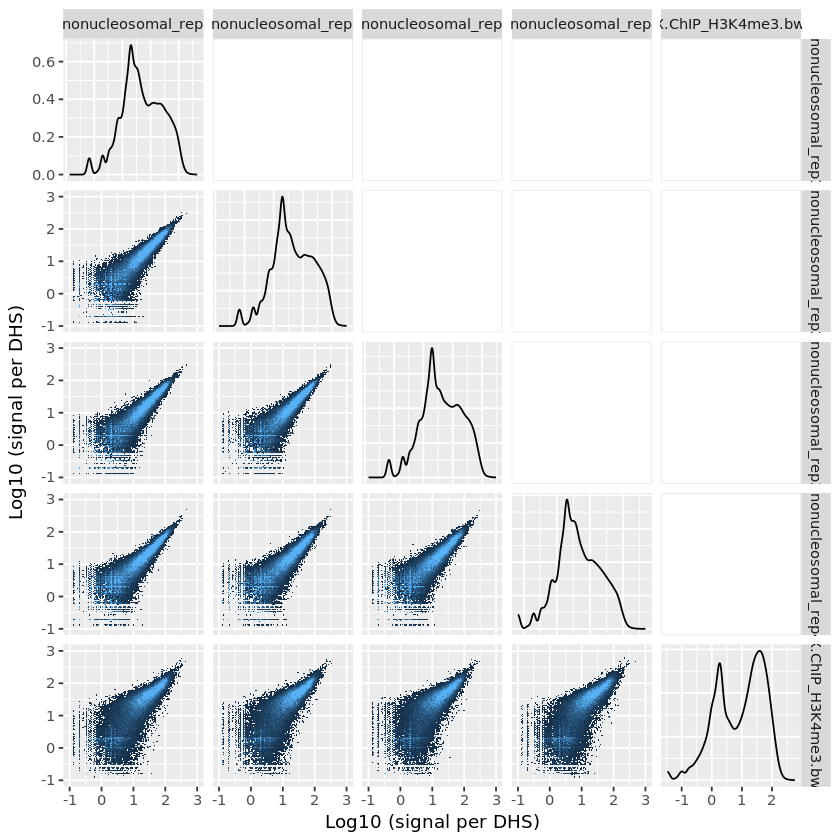

In [3]:
lims <- c(-1,3,50)
coverage <- read.csv("MChIPC_output/mononucleosomal_and_ChIP/H3K4me3_coverage.txt", header = T, sep = "\t")
ggpairs(log10(coverage[,4:8]), lower = list(continuous=wrap(GGscatterhex))) +
labs(x="Log10 (signal per DHS)",y="Log10 (signal per DHS)")

In [4]:
ggsave("Figures/Fig.S1/S1d_ChIP_correlation.pdf",device="pdf")

Saving 6.67 x 6.67 in image


# Calculating Pearson’s correlation coefficients

In [5]:
print(paste0("r(rep1,rep2)=",round(cor(coverage$X.Mononucleosomal_rep1.bw.,coverage$X.Mononucleosomal_rep2.bw.),2)))
print(paste0("r(rep1,rep3)=",round(cor(coverage$X.Mononucleosomal_rep1.bw.,coverage$X.Mononucleosomal_rep3.bw.),2)))
print(paste0("r(rep1,rep4)=",round(cor(coverage$X.Mononucleosomal_rep1.bw.,coverage$X.Mononucleosomal_rep4.bw.),2)))
print(paste0("r(rep1,ChIP)=",round(cor(coverage$X.Mononucleosomal_rep1.bw.,coverage$X.ChIP_H3K4me3.bw.),2)))
print(paste0("r(rep2,rep3)=",round(cor(coverage$X.Mononucleosomal_rep2.bw.,coverage$X.Mononucleosomal_rep3.bw.),2)))
print(paste0("r(rep2,rep4)=",round(cor(coverage$X.Mononucleosomal_rep2.bw.,coverage$X.Mononucleosomal_rep4.bw.),2)))
print(paste0("r(rep2,ChIP)=",round(cor(coverage$X.Mononucleosomal_rep2.bw.,coverage$X.ChIP_H3K4me3.bw.),2)))
print(paste0("r(rep3,rep4)=",round(cor(coverage$X.Mononucleosomal_rep3.bw.,coverage$X.Mononucleosomal_rep4.bw.),2)))
print(paste0("r(rep3,ChIP)=",round(cor(coverage$X.Mononucleosomal_rep3.bw.,coverage$X.ChIP_H3K4me3.bw.),2)))
print(paste0("r(rep4,ChIP)=",round(cor(coverage$X.Mononucleosomal_rep4.bw.,coverage$X.ChIP_H3K4me3.bw.),2)))

[1] "r(rep1,rep2)=0.96"
[1] "r(rep1,rep3)=0.96"
[1] "r(rep1,rep4)=0.96"
[1] "r(rep1,ChIP)=0.91"
[1] "r(rep2,rep3)=0.97"
[1] "r(rep2,rep4)=0.95"
[1] "r(rep2,ChIP)=0.92"
[1] "r(rep3,rep4)=0.95"
[1] "r(rep3,ChIP)=0.91"
[1] "r(rep4,ChIP)=0.9"


# Plotting a heatmap of CAGE-signal around MChIP-C viewpoints and around other DNase sensitive sites

In [6]:
DHSs <- read.csv("Auxiliary_data/ENCFF621ZJY.bed.gz", header = F, sep = "\t")
DHSs <- filter(DHSs, V7 > 200)
DHS_ranges <- GRanges(seqnames = DHSs$V1, 
                        ranges=IRanges(start=DHSs$V2, end=DHSs$V3, enh_id = seq(1,nrow(DHSs))))
baits <- read.csv("MChIPC_output/mononucleosomal_and_ChIP/binned_peaks.bed", header = F, sep = "\t")
bait_ranges <- GRanges(seqnames = baits$V1, ranges=IRanges(start=baits$V2, end=baits$V3, enh_id = seq(1,nrow(baits))))
DHSs_outside_baits <- DHSs[-(as.data.frame(findOverlaps(DHS_ranges,bait_ranges))[,1]),]
print(paste0("There is ",nrow(DHSs_outside_baits)," DHSs outside MChIP-C viewpoints"))
write.table(DHSs_outside_baits, file="tmp/DHSs_outside_viewpoints.bed", col.names = F, row.names = F, 
            sep = "\t", quote = F)
system("wget -P tmp/ https://www.encodeproject.org/files/ENCFF019NPZ/@@download/ENCFF019NPZ.bigWig", intern=T)
system("wget -P tmp/ https://www.encodeproject.org/files/ENCFF550YWP/@@download/ENCFF550YWP.bigWig", intern=T)
system("wget -P tmp/ https://www.encodeproject.org/files/ENCFF233CVF/@@download/ENCFF233CVF.bigWig", intern=T)
system("wget -P tmp/ https://www.encodeproject.org/files/ENCFF570ONH/@@download/ENCFF570ONH.bigWig", intern=T)
system("bigwigCompare -b1 tmp/ENCFF019NPZ.bigWig -b2 tmp/ENCFF550YWP.bigWig --operation mean -p 16 -o tmp/CAGE_plus.bw", 
       intern=T)
system("bigwigCompare -b1 tmp/ENCFF233CVF.bigWig -b2 tmp/ENCFF570ONH.bigWig --operation mean -p 16 -o tmp/CAGE_minus.bw", 
       intern=T)
system("computeMatrix reference-point --referencePoint center -S Auxiliary_data/ENCFF352SET.bigWig MChIPC_output/mononucleosomal_and_ChIP/Mononucleosomal_mean.bw tmp/CAGE_plus.bw tmp/CAGE_minus.bw -R MChIPC_output/mononucleosomal_and_ChIP/binned_peaks.bed tmp/DHSs_outside_viewpoints.bed -p 8 -a 5000 -b 5000 -o tmp/matrix_figS1e -bs 250 --missingDataAsZero",
       intern=T)
system("plotHeatmap -m tmp/matrix_figS1e --colorMap OrRd -o Figures/Fig.S1/S1e_CAGE_heatmap.pdf --regionsLabel viewpoints distal_DHSs --samplesLabel DNase_sensitivity Mononucl_MChIPC CAGE_plus CAGE_minus --zMax 1.2 65 0.001 0.001 --yMax 1.2 65 0.03 0.03 --yMin 0", intern=T)
system("rm tmp/DHSs_outside_viewpoints.bed", intern=T)
system("rm tmp/ENCFF019NPZ.bigWig", intern=T)
system("rm tmp/ENCFF550YWP.bigWig", intern=T)
system("rm tmp/ENCFF233CVF.bigWig", intern=T)
system("rm tmp/ENCFF570ONH.bigWig", intern=T)
system("rm tmp/CAGE_plus.bw", intern=T)
system("rm tmp/CAGE_minus.bw", intern=T)
system("rm tmp/matrix_figS1e", intern=T)

[1] "There is 44443 DHSs outside MChIP-C viewpoints"


character(0)
attr(,"status")
[1] 4

character(0)
attr(,"status")
[1] 4

character(0)
attr(,"status")
[1] 4

character(0)
attr(,"status")
[1] 4

character(0)
attr(,"status")
[1] 1

character(0)
attr(,"status")
[1] 1

character(0)
attr(,"status")
[1] 1

character(0)
attr(,"status")
[1] 2

character(0)

character(0)
attr(,"status")
[1] 1

character(0)
attr(,"status")
[1] 1

character(0)
attr(,"status")
[1] 1

character(0)
attr(,"status")
[1] 1

character(0)
attr(,"status")
[1] 1

character(0)
attr(,"status")
[1] 1

character(0)
attr(,"status")
[1] 1

# Plotting distance-dependent decay of MChIP-C signal in replicates

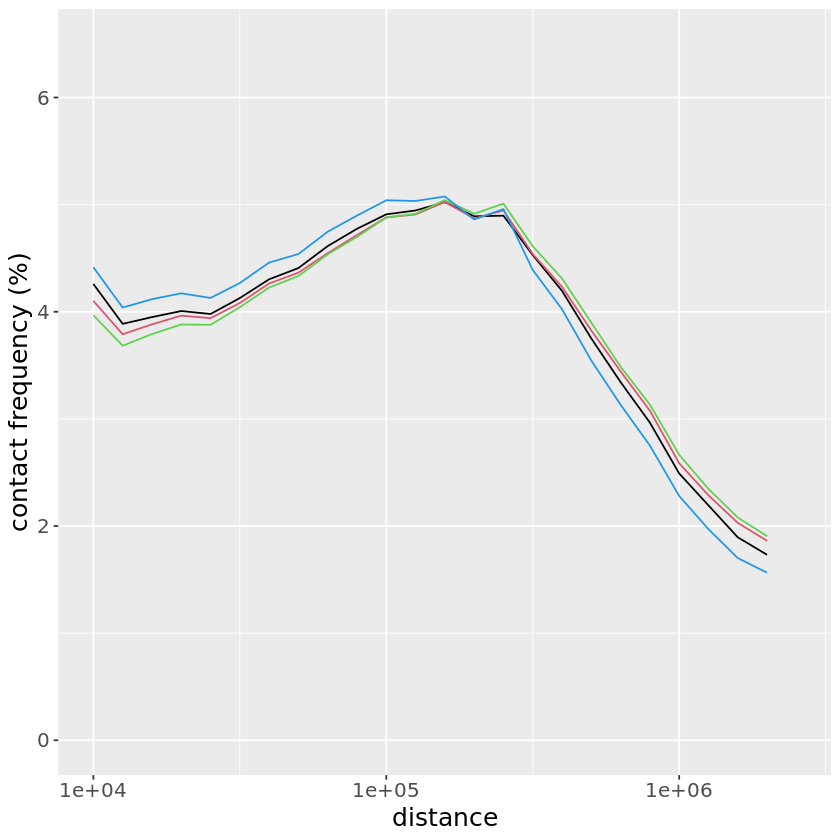

In [7]:
interactions <- read.csv("MChIPC_output/MChIPC_interaction_data.txt", header = T, sep = "\t")
interactions <- interactions[,1:10]
interactions$distance <- log10(abs((interactions$vp_start+interactions$vp_end)/2-(interactions$OE_start+interactions$OE_end)/2))
interactions <- filter(interactions, distance < 7)
mask <- read.csv("MChIPC_output/mononucleosomal_and_ChIP/H3K4me3.mask.bed", header = F, sep = "\t")[,c(1:3)]
interactions_ranges <- GRanges(seqnames = interactions$OE_chr, ranges=IRanges(start=interactions$OE_start, 
                        end=interactions$OE_end, enh_id = seq(1,nrow(interactions))))
mask_ranges <- GRanges(seqnames = mask$V1, ranges=IRanges(start=mask$V2, end=mask$V3, enh_id = seq(1,nrow(mask))))
interactions_mod <- interactions[-(unique(as.data.frame(findOverlaps(interactions_ranges,mask_ranges))[,1])),7:11]
interactions_mod <- interactions_mod %>% mutate(bin = cut(distance, breaks=seq(3.5,6.5,0.1), labels=FALSE))
interactions_mod$sum <- interactions_mod$N_rep1 + interactions_mod$N_rep2 + 
                        interactions_mod$N_rep3 + interactions_mod$N_rep4
summary <- interactions_mod%>%group_by(bin)%>%summarise(N_rep1=sum(N_rep1),N_rep2=sum(N_rep2),
                                                        N_rep3=sum(N_rep3),N_rep4=sum(N_rep4))
summary$N_rep1 <- 100*summary$N_rep1/sum(summary$N_rep1)
summary$N_rep2 <- 100*summary$N_rep2/sum(summary$N_rep2)
summary$N_rep3 <- 100*summary$N_rep3/sum(summary$N_rep3)
summary$N_rep4 <- 100*summary$N_rep4/sum(summary$N_rep4)
summary$distance <- 10^(3.5+summary$bin*0.1)
ggplot(summary) + geom_line(aes(x=distance, y=N_rep1), color=1) + geom_line(aes(x=distance, y=N_rep2), color=2) + 
geom_line(aes(x=distance, y=N_rep3), color=3)+geom_line(aes(x=distance, y=N_rep4), color=4) + 
scale_x_log10(limits=c(10000,2500000)) + ylab("contact frequency (%)") + ylim(0,6.5) +
theme(text=element_text(size=15))

In [8]:
ggsave("Figures/Fig.S1/S1g_MChIPC_signal_decay.pdf",device="pdf")

Saving 6.67 x 6.67 in image


# Plotting hexagonal heatmaps of pairwise comparison of MChIP signals separated by viewpoints

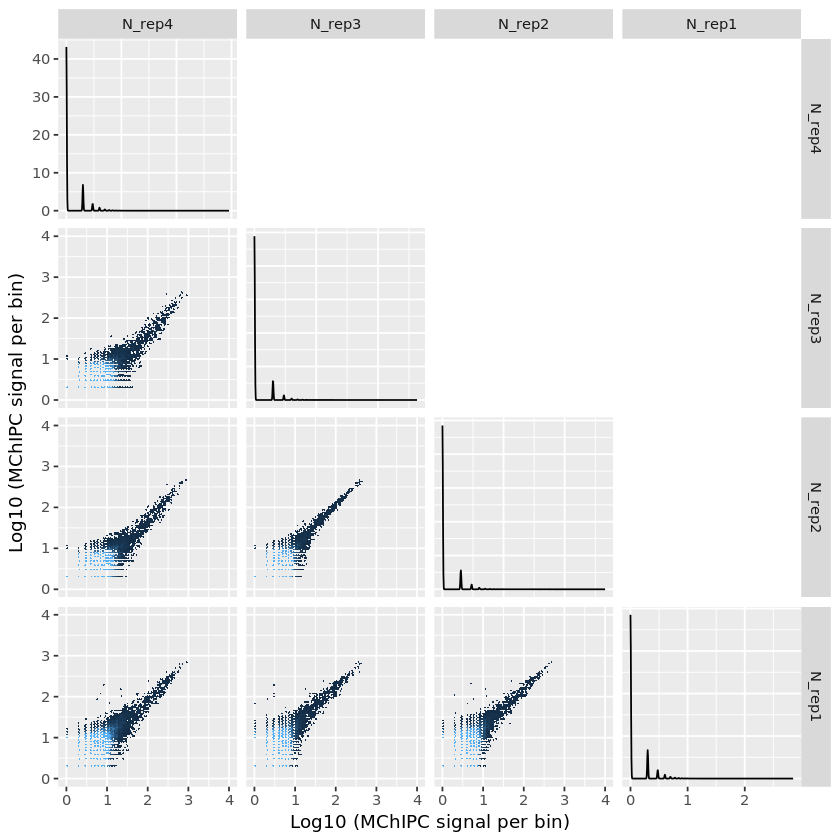

In [9]:
rm(list=c("coverage", "interactions_mod", "summary", "mask", "mask_ranges"))
lims <- c(0,4,100)
interactions <- filter(interactions, distance < 6)
interactions_ranges <- GRanges(seqnames = interactions$OE_chr,
            ranges=IRanges(start=interactions$OE_start, end=interactions$OE_end))
interactions <- interactions[-(as.data.frame(findOverlaps(interactions_ranges,bait_ranges))[,1]),]
ggpairs(log10(interactions[,10:7]), lower = list(continuous=wrap(GGscatterhex)), upper = list(continuous = "blank"))+
labs(x="Log10 (MChIPC signal per bin)",y="Log10 (MChIPC signal per bin)")

In [10]:
ggsave("Figures/Fig.S1/S1f_MChIPC_correlation_sep.pdf",device="pdf")

Saving 6.67 x 6.67 in image


In [11]:
# Calculating Pearson’s correlation coefficients
print(paste0("r_sep(rep1,rep2)=",round(cor(interactions$N_rep1, interactions$N_rep2),2)))
print(paste0("r_sep(rep1,rep3)=",round(cor(interactions$N_rep1, interactions$N_rep3),2)))
print(paste0("r_sep(rep1,rep4)=",round(cor(interactions$N_rep1, interactions$N_rep4),2)))
print(paste0("r_sep(rep2,rep3)=",round(cor(interactions$N_rep2, interactions$N_rep3),2)))
print(paste0("r_sep(rep2,rep4)=",round(cor(interactions$N_rep2, interactions$N_rep4),2)))
print(paste0("r_sep(rep3,rep4)=",round(cor(interactions$N_rep3, interactions$N_rep4),2)))

[1] "r_sep(rep1,rep2)=0.62"
[1] "r_sep(rep1,rep3)=0.6"
[1] "r_sep(rep1,rep4)=0.7"
[1] "r_sep(rep2,rep3)=0.59"
[1] "r_sep(rep2,rep4)=0.67"
[1] "r_sep(rep3,rep4)=0.63"


# Plotting hexagonal heatmaps of pairwise comparison of merged MChIP signals

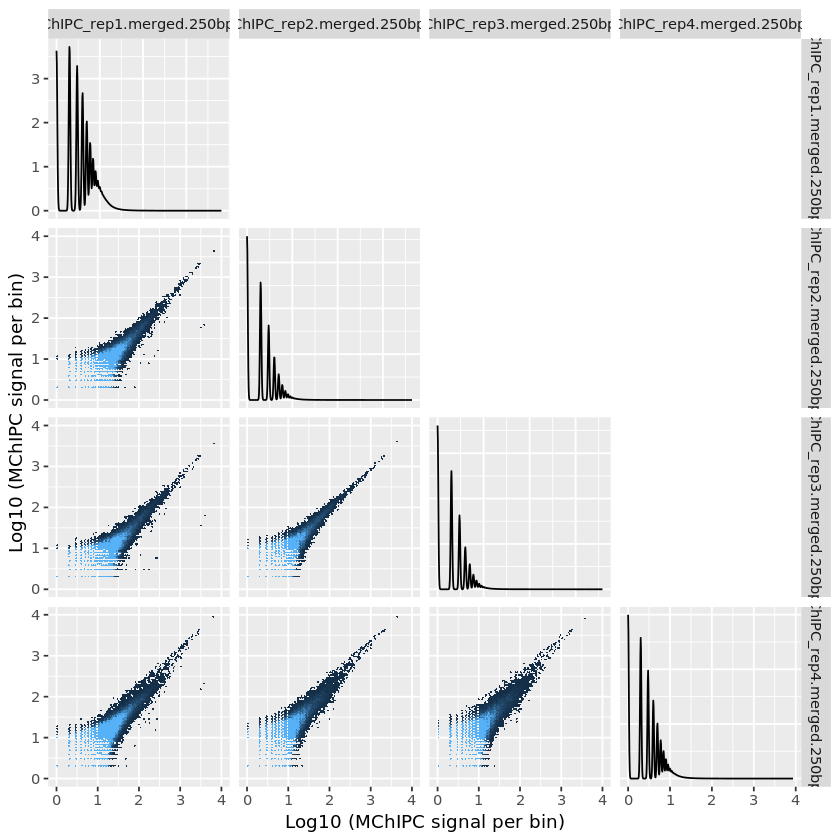

In [12]:
rm(interactions)
multi <- read.csv("MChIPC_output/aggregate_profiles/replicates_coverage.txt", header = T, sep = "\t")
multi <- filter(multi, (X.MChIPC_rep1.merged.250bp.bw.>0&X.MChIPC_rep2.merged.250bp.bw.>0&
                        X.MChIPC_rep3.merged.250bp.bw.>0&X.MChIPC_rep4.merged.250bp.bw.>0))
multi_ranges <- GRanges(seqnames = multi$X..chr., ranges=IRanges(start=multi$X.start., 
                        end=multi$X.end.))
multi <- multi[-(as.data.frame(findOverlaps(multi_ranges,bait_ranges))[,1]),]
ggpairs(log10(multi[,4:7]), lower = list(continuous=wrap(GGscatterhex)), upper=list(continuous = "blank"))+
labs(x="Log10 (MChIPC signal per bin)",y="Log10 (MChIPC signal per bin)")

In [13]:
ggsave("Figures/Fig.S1/S1f_MChIPC_correlation_merged.pdf",device="pdf")

Saving 6.67 x 6.67 in image


In [14]:
# Calculating Pearson’s correlation coefficients
print(paste0("r_merged(rep1,rep2)=",round(cor(multi$X.MChIPC_rep1.merged.250bp.bw.,multi$X.MChIPC_rep2.merged.250bp.bw.),2)))
print(paste0("r_merged(rep1,rep3)=",round(cor(multi$X.MChIPC_rep1.merged.250bp.bw.,multi$X.MChIPC_rep3.merged.250bp.bw.),2)))
print(paste0("r_merged(rep1,rep4)=",round(cor(multi$X.MChIPC_rep1.merged.250bp.bw.,multi$X.MChIPC_rep4.merged.250bp.bw.),2)))
print(paste0("r_merged(rep2,rep3)=",round(cor(multi$X.MChIPC_rep2.merged.250bp.bw.,multi$X.MChIPC_rep3.merged.250bp.bw.),2)))
print(paste0("r_merged(rep2,rep4)=",round(cor(multi$X.MChIPC_rep2.merged.250bp.bw.,multi$X.MChIPC_rep4.merged.250bp.bw.),2)))
print(paste0("r_merged(rep3,rep4)=",round(cor(multi$X.MChIPC_rep3.merged.250bp.bw.,multi$X.MChIPC_rep4.merged.250bp.bw.),2)))

[1] "r_merged(rep1,rep2)=0.91"
[1] "r_merged(rep1,rep3)=0.9"
[1] "r_merged(rep1,rep4)=0.9"
[1] "r_merged(rep2,rep3)=0.95"
[1] "r_merged(rep2,rep4)=0.95"
[1] "r_merged(rep3,rep4)=0.93"


# Calculating numbers of P-P and P-PIR interactions in MChIP-C data 

In [15]:
rm(list=c("multi"))
loops <-read.csv("MChIPC_output/MChIPC_interactions.bedpe", header = F, sep = "\t")
loops$V7 <- 0
loops$V7[loops$V2>loops$V5] <- -((loops$V2[loops$V2>loops$V5]-loops$V6[loops$V2>loops$V5])/250+1)
loops$V7[loops$V2<loops$V5] <- (loops$V5[loops$V2<loops$V5]-loops$V3[loops$V2<loops$V5])/250+1
loops$distance <- abs((loops$V2+loops$V3)/2 - (loops$V5+loops$V6)/2)
loops_OE_ranges <- GRanges(seqnames = loops$V4,ranges=IRanges(start=loops$V5,end=loops$V6,enh_id=seq(1,nrow(loops))))
loops$type <- "P-PIR"
loops$type[as.data.frame(findOverlaps(loops_OE_ranges,bait_ranges))[,1]] <- "P-P"
colnames(baits) <- c("vp_chr","vp_start","vp_end")
PP_loops <- bind_cols(loops[(as.data.frame(findOverlaps(loops_OE_ranges,bait_ranges))[,1]),],
                      baits[(as.data.frame(findOverlaps(loops_OE_ranges,bait_ranges))[,2]),])[,c(1:3,10:12)]
colnames(PP_loops) <- c("V1","V2","V3","V4","V5","V6")
PP_loops$V7 <- PP_loops$V2
PP_loops$V8 <- PP_loops$V3
for (i in seq(1:nrow(PP_loops))){
  if (PP_loops$V2[i] > PP_loops$V5[i]){
    PP_loops$V2[i] <- PP_loops$V5[i]
    PP_loops$V3[i] <- PP_loops$V6[i]
    PP_loops$V5[i] <- PP_loops$V7[i]
    PP_loops$V6[i] <- PP_loops$V8[i]}}
PP_loops <- PP_loops[,1:6]
PPIR_loops <- loops[-(as.data.frame(findOverlaps(loops_OE_ranges,bait_ranges))[,1]),]
print(paste0("There is ",nrow(PP_loops)," P-P loops, corresponding to ",nrow(unique(PP_loops)),
             " unique P-P interactions,"))
print(paste0("and there is ",nrow(loops)-nrow(PP_loops)," P-PIR loops, linking ",nrow(unique(PPIR_loops[,1:3])),
             " viewpoints with ", nrow(unique(PPIR_loops[,4:6])), " unique PIRs"))

[1] "There is 112118 P-P loops, corresponding to 19369 unique P-P interactions,"
[1] "and there is 129241 P-PIR loops, linking 10679 viewpoints with 99552 unique PIRs"


# Calculating proportion of PIRs overlapping CTCF-sites or other DHSs

In [16]:
CTCF_peaks <- read.csv("Auxiliary_data/ENCFF002CEL.bed.gz", header = F, sep = "\t")
CTCF_peaks <- filter(CTCF_peaks, V5 > 250)
CTCF_ranges <- GRanges(seqnames = CTCF_peaks$V1, 
                       ranges=IRanges(start=CTCF_peaks$V2, end=CTCF_peaks$V3, enh_id = seq(1,nrow(CTCF_peaks))))
PIRs <- unique(PPIR_loops[,4:6])
PIR_ranges <- GRanges(seqnames = PIRs$V4, ranges=IRanges(start=PIRs$V5, end=PIRs$V6, enh_id = seq(1,nrow(PIRs))))
PIRs_wo_CTCF <- PIRs[-(unique(as.data.frame(findOverlaps(PIR_ranges,CTCF_ranges))[,1])),]
PIR_wo_CTCF_ranges <- GRanges(seqnames = PIRs_wo_CTCF$V4,
                    ranges=IRanges(start=PIRs_wo_CTCF$V5, end=PIRs_wo_CTCF$V6, enh_id = seq(1,nrow(PIRs_wo_CTCF))))
print(paste0("There are ", length(unique(as.data.frame(findOverlaps(PIR_ranges,CTCF_ranges))[,1])), "(",
            round(length(unique(as.data.frame(findOverlaps(PIR_ranges,CTCF_ranges))[,1]))*100/nrow(PIRs),2), 
            "%) PIRs overlapping CTCF-bound site and ",
            length(unique(as.data.frame(findOverlaps(PIR_wo_CTCF_ranges,DHS_ranges))[,1])), "(", 
            round(length(unique(as.data.frame(findOverlaps(PIR_wo_CTCF_ranges,DHS_ranges))[,1]))*100/nrow(PIRs),2), 
            "%) PIRs with DHS"))

[1] "There are 20447(20.54%) PIRs overlapping CTCF-bound site and 11343(11.39%) PIRs with DHS"


# Analysis of expected and observed cross-TAD-boundary interactions

In [17]:
TADs <- read.csv("Auxiliary_data/HiC_K562_IS_10kb.txt", header = F, sep = " ")
TAD_ranges <- GRanges(seqnames = TADs$V1, ranges=IRanges(start=TADs$V2, end=TADs$V3, enh_id = seq(1,nrow(TADs))))
loop_origin_ranges <-GRanges(seqnames=loops$V1,ranges=IRanges(start=loops$V2,end=loops$V3,enh_id=seq(1,nrow(loops)))) 
loop_OE_ranges <- GRanges(seqnames=loops$V4,ranges=IRanges(start=loops$V5,end=loops$V6,enh_id=seq(1,nrow(loops))))
loops$queryHits <- seq(nrow(loops))
loops <- suppressMessages({left_join(loops, as.data.frame(findOverlaps(loop_origin_ranges, TAD_ranges)))})
colnames(loops)[11] <- "bait_TAD"
loops <- suppressMessages({left_join(loops, as.data.frame(findOverlaps(loop_OE_ranges, TAD_ranges)))})
colnames(loops)[12] <- "OE_TAD"
loops_PP <- filter(loops, type=="P-P")
loops_PPIR <- filter(loops, type=="P-PIR")
proportion_in_TAD_PP <- sum(loops_PP$bait_TAD == loops_PP$OE_TAD, na.rm = TRUE) / 
                        nrow(filter(loops_PP, !(is.na(bait_TAD))&!(is.na(OE_TAD))))
proportion_in_TAD_PPIR <- sum(loops_PPIR$bait_TAD == loops_PPIR$OE_TAD, na.rm = TRUE) / 
                         nrow(filter(loops_PPIR, !(is.na(bait_TAD))&!(is.na(OE_TAD))))

set.seed(3)
# reshuffling P-P loops 100 times
proportion_in_TAD_PP_randomized <- c()
for (i in seq(100)){
  randomized_OE <- loops_PP[,1:6]
  randomized_OE$V7 <- sample(loops_PP$V7)
  randomized_pos <- filter(randomized_OE, V7 > 0)
  randomized_neg <- filter(randomized_OE, V7 < 0)
  randomized_pos$V6 <- randomized_pos$V3 + randomized_pos$V7*250
  randomized_pos$V5 <- randomized_pos$V6 - 250
  randomized_neg$V5 <- randomized_neg$V2 + randomized_neg$V7*250
  randomized_neg$V6 <- randomized_neg$V5 + 250
  rand <- bind_rows(randomized_pos, randomized_neg)
  loop_origin_ranges <- GRanges(seqnames = rand$V1, ranges=IRanges(start=rand$V2, 
                                                                   end=rand$V3, enh_id = seq(1,nrow(rand)))) 
  loop_OE_ranges <- GRanges(seqnames = rand$V4, ranges=IRanges(start=rand$V5,
                                                               end=rand$V6, enh_id = seq(1,nrow(rand))))
  rand$queryHits <- seq(nrow(rand))
  rand <- suppressMessages({left_join(rand, as.data.frame(findOverlaps(loop_origin_ranges, TAD_ranges)))})
  colnames(rand)[9] <- "bait_TAD"
  rand <- suppressMessages({left_join(rand, as.data.frame(findOverlaps(loop_OE_ranges, TAD_ranges)))})
  colnames(rand)[10] <- "OE_TAD"
  proportion_in_TAD_PP_randomized <- append(proportion_in_TAD_PP_randomized, 
         sum(rand$bait_TAD == rand$OE_TAD, na.rm = TRUE) / nrow(filter(rand, !(is.na(bait_TAD))&!(is.na(OE_TAD)))))}
print(paste0(100*round(1-proportion_in_TAD_PP, 4),"% P-P loops cross at least one TAD boundary, while ", 
             100*round(1-mean(proportion_in_TAD_PP_randomized),4), 
             "% is expected by chance (sd=", 100*round(sd(proportion_in_TAD_PP_randomized),4),")"))

# reshuffling P-PIR loops 100 times
proportion_in_TAD_PPIR_randomized <- c()
for (i in seq(100)){
  randomized_OE <- loops_PPIR[,1:6]
  randomized_OE$V7 <- sample(loops_PPIR$V7)
  randomized_pos <- filter(randomized_OE, V7 > 0)
  randomized_neg <- filter(randomized_OE, V7 < 0)
  randomized_pos$V6 <- randomized_pos$V3 + randomized_pos$V7*250
  randomized_pos$V5 <- randomized_pos$V6 - 250
  randomized_neg$V5 <- randomized_neg$V2 + randomized_neg$V7*250
  randomized_neg$V6 <- randomized_neg$V5 + 250
  rand <- bind_rows(randomized_pos, randomized_neg)
  loop_origin_ranges <- GRanges(seqnames = rand$V1, ranges=IRanges(start=rand$V2, 
                                                                   end=rand$V3, enh_id = seq(1,nrow(rand)))) 
  loop_OE_ranges <- GRanges(seqnames = rand$V4, ranges=IRanges(start=rand$V5, 
                                                               end=rand$V6, enh_id = seq(1,nrow(rand))))
  rand$queryHits <- seq(nrow(rand))
  rand <- suppressMessages({left_join(rand, as.data.frame(findOverlaps(loop_origin_ranges, TAD_ranges)))})
  colnames(rand)[9] <- "bait_TAD"
  rand <- suppressMessages({left_join(rand, as.data.frame(findOverlaps(loop_OE_ranges, TAD_ranges)))})
  colnames(rand)[10] <- "OE_TAD"
  proportion_in_TAD_PPIR_randomized <- append(proportion_in_TAD_PPIR_randomized, 
         sum(rand$bait_TAD == rand$OE_TAD, na.rm = TRUE) / nrow(filter(rand, !(is.na(bait_TAD))&!(is.na(OE_TAD)))))}
print(paste0(100*round(1-proportion_in_TAD_PPIR, 4),"% P-PIR loops cross at least one TAD boundary, while ", 
             100*round(1-mean(proportion_in_TAD_PPIR_randomized),4), 
             "% is expected by chance (sd=", 100*round(sd(proportion_in_TAD_PPIR_randomized),4),")"))

[1] "6.19% P-P loops cross at least one TAD boundary, while 9.12% is expected by chance (sd=0.08)"
[1] "5.37% P-PIR loops cross at least one TAD boundary, while 7.86% is expected by chance (sd=0.07)"
